<h1>Extract salt and temp from ROMS file on MET Norway thredds</h1>
General example on how to extract data from ROMS model on MET Norway thredds server

In [1]:
import netCDF4
import numpy as np
import datetime
import sys
import matplotlib.pyplot as plt
import roppy # https://github.com/bjornaa/roppy

Define code used in this example:

In [2]:
def roms_latlon2xy(f,lat,lon,roundvals=True):
    a = abs( f.variables['lat_rho'][:]-lat ) + abs( f.variables['lon_rho'][:]-lon )
    y_coord, x_coord = np.unravel_index(a.argmin(), a.shape)
    if roundvals:
        x_coord = int(np.round(x_coord))
        y_coord = int(np.round(y_coord))
    return x_coord, y_coord

def BFS(start_i, start_j, arr, crit=1):
    """
    Code from josteinb@met.no

    desc:
        Breadth first search function to find index of nearest
        point with crit value (default crit=1 for finding ROMS
        wet-point in mask)
    args:
        - start_i: Start index of i
        - start_j: Start index of j
        - arr: grid with data
        - crit: value to search for (deafult unmasked point)
    return:
        - index of point
    """
    dirs    = [(1,0), (-1,0), (0,1),(0,-1)]
    visited = set()
    q       = [(start_i, start_j)]    # init queue to start pos
    count   = 0
    arrays  = list()  # for storing frames if plotting
    # while something in queue
    while q:
        current = q.pop(0)      # pop the first in waiting queue
        # if we have visited this before
        if current in visited:
            continue
        visited.add(current)    # Add to set of visited
        # If not in border list
        # Test if this is land, if true go to next in queue, else return idx
        if arr[current[0], current[1]] == crit:
            return current[0], current[1]
        count += 1      #updates the count
        # Loop over neighbours and add to queue
        for di, dj in dirs:
            new_i = current[0]+di
            new_j = current[1]+dj
            q.append((new_i, new_j))

def get_z(grd):
    import roppy
    h      = grd.variables['h']
    C      = grd.variables['Cs_r'][:]
    Cw     = grd.variables['Cs_w'][:]
    Hc     = grd.variables['hc'].getValue()
    vtrans = grd.variables['Vtransform'].getValue()
    z_rho  = roppy.sdepth(h, Hc, C, Vtransform=vtrans)
    z_w    = roppy.sdepth(h, Hc, Cw, Vtransform=vtrans)
    return z_rho, z_w

"User input" should be put in this box:

In [24]:
date = "20230928"  # date is needed for correct file name
filename = f"https://thredds.met.no/thredds/dodsC/fjordos/operational_archive/complete_archive/ocean_his.nc_{date}00"

nc       = netCDF4.Dataset(filename)
lat      = [59.8870536] 
lon      = [10.6654982]
name     = ['Station 3, leg 2']
times    = [datetime.datetime(2023,9,28,13)]  # Format year, month, day, hour. Date needs to be the same as  "date" above.

In [26]:
# Check all arrays length:
if not (len(lat) == len(lon) == len(name) == len(times)):   
    print('Error in array lengths')
    raise()

In [27]:
# Read vertical layers depth:
z_rho, z_w = get_z(nc)

Looping over all stations defined above and printing the salt and temp, and plot the data in a simple fashion:

user defined lat: 59.8870536, lon: 10.6654982
model lat: 59.88700028805397, lon: 10.665695977682812
Station 3, leg 2: 205, 852 (x, y), salt: [34.78595  34.712597 34.63043  34.528805 34.408684 34.339554 34.243595
 34.158558 34.064915 33.99523  33.9247   33.84474  33.720352 33.558784
 33.398365 33.253857 33.101955 32.829163 32.504242 32.145096 31.746658
 31.282127 30.836563 30.2527   29.629164 29.030977 27.872492 27.070427
 26.526321 25.654852 24.762524 24.3193   24.186495 24.120655 24.057854
 23.97939  23.834824 23.585295 23.386497 23.40685  23.410046 23.41521 ], temp: [ 6.7596436  6.981968   7.1957707  7.3789263  7.555977   7.6202683
  7.7566123  7.958762   8.166754   8.354358   8.477239   8.734364
  9.038292   9.36355    9.753026  10.033856  10.490283  10.791908
 11.307987  11.872682  12.416867  12.798144  13.141989  13.482316
 13.750273  13.981559  14.496297  14.876564  15.0783415 15.393379
 15.796852  15.823146  15.750027  15.720873  15.752019  15.710522
 15.754261  15.824821  15.83

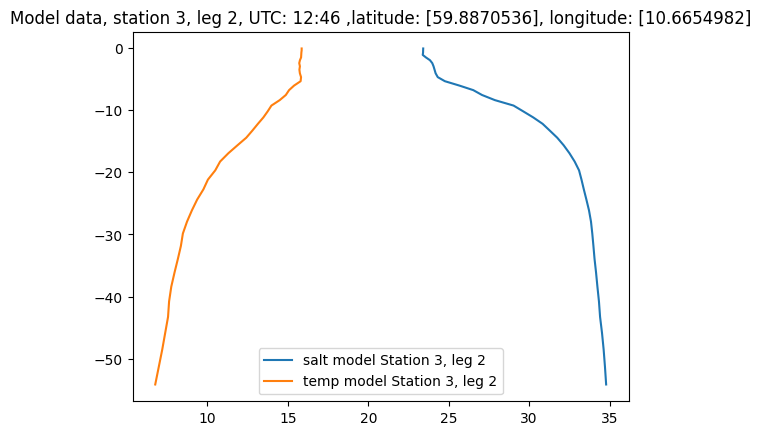

In [28]:
# Loop over all stations:
for i in range(len(name)):
    x, y = roms_latlon2xy(nc, lat[i], lon[i]) # find x and y indexes
    t    = np.where(netCDF4.num2date(nc.variables['ocean_time'][:], nc.variables['ocean_time'].units) == times[i])[0][0] # find time index
    mask = nc.variables['mask_rho'][:]
    if mask[y,x] == 0:
        print('Position is on land, will find nearest wet gridpoint')
        y, x = BFS(y,x,mask)
    salt = nc.variables['salt'][t,:,y,x]
    temp = nc.variables['temp'][t,:,y,x]
    print('user defined lat: {}, lon: {}'.format(lat[i], lon[i]))
    print('model lat: {}, lon: {}'.format(nc.variables['lat_rho'][y,x], nc.variables['lon_rho'][y,x]))
    print('{}: {}, {} (x, y), salt: {}, temp: {}'.format(name[i], x, y, salt, temp))
    print('-------------------------')
    plt.plot(salt, z_rho[:,y,x], label='salt model {}'.format(name[i]))
    plt.plot(temp, z_rho[:,y,x], label='temp model {}'.format(name[i]))
plt.title(f"Model data, station 3, leg 2, UTC: 12:46 ,latitude: {lat}, longitude: {lon}")
plt.legend()
plt.show()